In [387]:
import math

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)

        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __neg__(self, other):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supprting int/float powers"
        out = Value(self.data**other, (self,), f'**{other}')
        def _back():
            self.grad += other * (self.data**(other-1)) * out.grad

        out._backward = _back
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad +=  (1-out.data**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):

        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _back():
            self.grad += out.data * out.grad

        out._backward = _back

        return out

In [24]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [102]:
h = 0.0001

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'

L.grad = 1

L


# L=d*f
# dL/dd =? (f)
# ^ d prefix probably means derivative?

# Explanation
# (f(x+h)-f(x))/h
# ((d+h)*f-d*f)/h
# (d*f + h*f - d*f)/h
# (d*f)/h + f - (d*f)/h
# f

Value(data=-8.0)

In [27]:
# Manual backpropagation
f.grad = 4.0 # f changes by d
d.grad = -2.0 # d changes by f
# they have direct effect on L

In [28]:
# How to understand all of backpropagation
# How does L change when c changes
# dL / dc

# We know how L depends on d
# How is L sensitive to c
# If you know how much d impacts L and how much c impacts d, you should know how much c impacts L

# First, what is dd/dc
# When c changes 1, d changes 1
# so dd/dc should be 1
# You can always go back to (f(x+h) - f(x))/h
# d = c + e

# chain rule calculus
# d(z/x) = d(z/y)*d(y/x)
# d(L/c) = d(L/d) * d(L/d)
# d(L/c) = -2 * 1 = -2

c.grad = -2.0
e.grad = -2.0

# why is e.grad also -2? same reason as c.grad

In [31]:
# Last chain rule
# How does L change when a changes?
# How does L change when b changes?

# d(L/e) = -2.0
# d(e/a) = -3.0 (value of b since is multiply)
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2

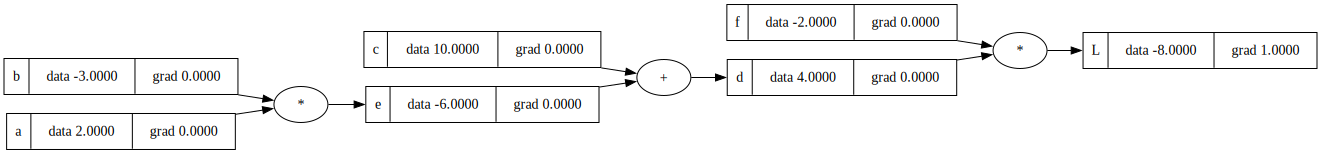

In [103]:
draw_dot(L)

In [20]:
# Increment leaf nodes
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad


# Rerun Forward Pass
e = a*b
d = e+c
L = d*f

print(L.data)

-7.286496


In [21]:
def testing_derivative():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    e.data += h

    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)

testing_derivative()

-1.9999999999953388


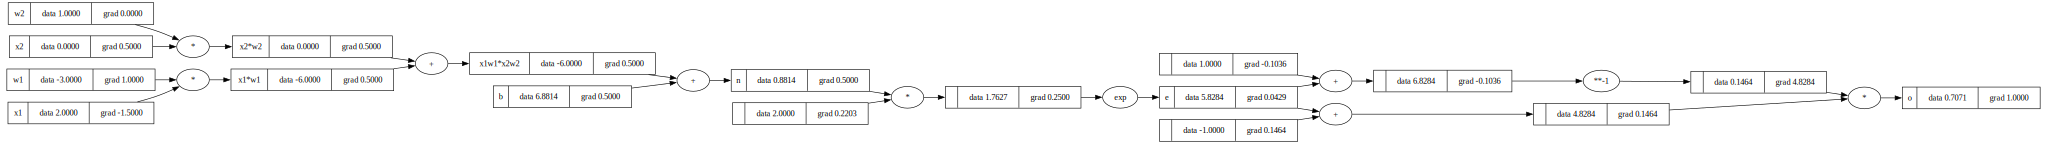

In [403]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the Neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1*x2w2'
n = x1w1x2w2 + b; n.label='n'

e = (2*n).exp(); e.label = 'e'
o = (e - 1)/(e+1)
o.label = 'o'
# o = n.tanh()
o.backward()
draw_dot(o)


In [174]:
o.grad = 1

In [166]:
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()


In [73]:
# o = tanh(n)
# derivative of tanh is 1 - tanh(n)^2
# derivative = 1 - o**2
# do/dn = 1 - o**2
grad = 1-o.data**2 
n.grad = 0.5
grad

0.4999999999999999

In [76]:
# Chain rule 0.5 * 1 (since + operator is being used)

b.grad = 0.5
x1w1x2w2.grad = 0.5

In [78]:
x2w2.grad = 0.5
x1w1.grad = 0.5

In [86]:
w2.grad = x2w2.grad * x2.data
x2.grad = x2w2.grad * w2.data
w1.grad = x1w1.grad * x1.data
x1.grad = x1w1.grad * w1.data

In [362]:
o.backward()

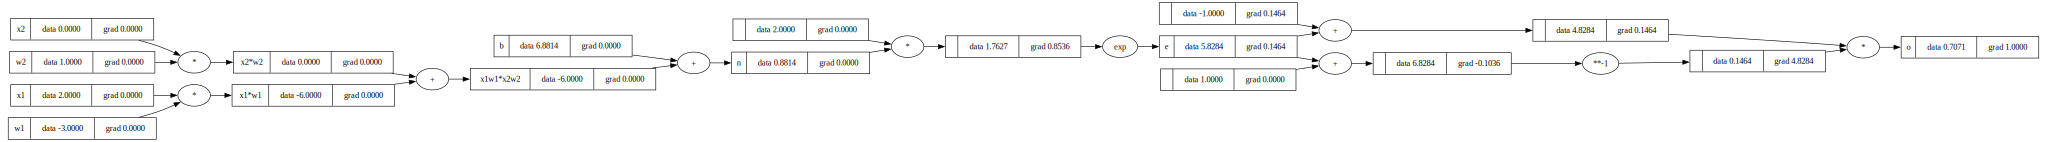

In [363]:
draw_dot(o)

{Value(data=6.0), Value(data=24.0)}


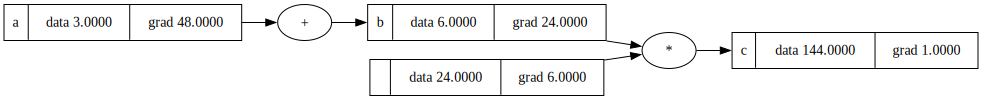

In [409]:
# bugfix 

a = Value(3.0, label='a')
b = a + a; b.label = 'b'

c = 24.0 * b; c.label = 'c'

c.backward()
print(c._prev)
draw_dot(c)

In [423]:
# Doing the same thing with pytorch

import torch

x1 = torch.Tensor([2.0]).double()                    ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                    ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                   ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                    ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()      ; b.requires_grad = True
n = x1*w1 + x2*w2+b
o = torch.tanh(n)
print(o.data.item())

o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

# Torch can do what we implemented in micrograd, when the torch only implements a single value


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [988]:
import random

class Neuron:
    """nin: number of inputs"""
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    """Forward pass"""
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in (zip(self.w, x))), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    """nout: number of neurons?"""
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params

class MLP:
    """nouts: list of nout"""
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        for layer in self.layers:
            ps = layer.parameters()
            params.extend(ps)
        return params

x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 1])
# draw_dot(n(x))
        

In [989]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0,5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [1199]:
# Fitting the neural net

for k in range(20):
    ypred = [n(x) for x in xs]
    # Mean squared error for loss function
    loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))

    # This is called zero_grad - resetting the grad to 0
    for p in n.parameters():
        p.grad = 0
    
    loss.backward()

    # here you would decrease the learning rate over time
    for p in n.parameters():
        p.data += -0.1* p.grad
    print(k, loss.data)

0 7.324179134066056e-05
1 7.321858847056212e-05
2 7.319540011844222e-05
3 7.317222627074095e-05
4 7.31490669139242e-05
5 7.312592203446638e-05
6 7.31027916188648e-05
7 7.307967565363043e-05
8 7.305657412529119e-05
9 7.303348702039219e-05
10 7.301041432549879e-05
11 7.298735602718673e-05
12 7.296431211204675e-05
13 7.294128256669844e-05
14 7.291826737776318e-05
15 7.289526653188994e-05
16 7.287228001574004e-05
17 7.284930781598792e-05
18 7.282634991933194e-05
19 7.280340631248076e-05


In [1201]:
ypred # This is the prediction of the neural net

[Value(data=0.996126164876491),
 Value(data=-0.995523137042612),
 Value(data=-0.9955844270715566),
 Value(data=0.9957271529956347)]

In [1108]:
n.layers[0].neurons[0].w[0].grad

-4.113064005578065e-06

In [1109]:
n.layers[0].neurons[0].w[0].data

-0.6964307001233129

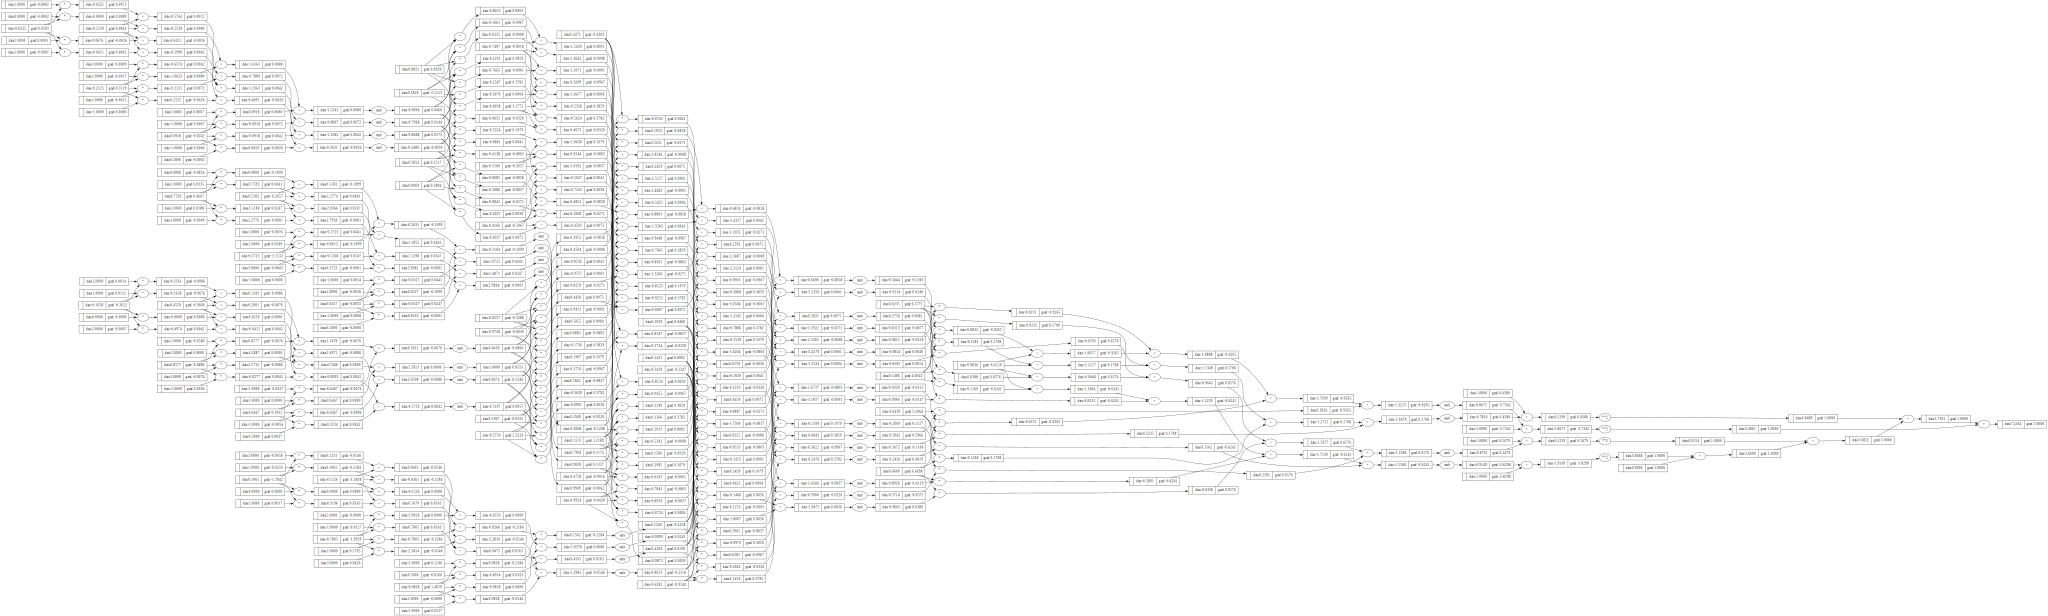

In [672]:
draw_dot(loss)